Expected #wins: 3.9662310149591247
count    22.000000
mean      0.102842
std       0.484993
min      -0.493533
25%      -0.236795
50%       0.060246
75%       0.226944
max       1.411842
dtype: float64


<AxesSubplot:ylabel='Count'>

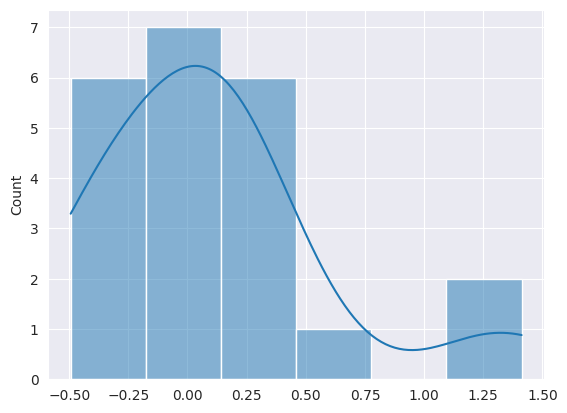

In [1]:
from typing import List, Tuple
import seaborn as sns
import pandas as pd

def get_win_prob_diffs(bet_odds_sp_pairs: List[Tuple[float, float]]) -> List[float]:
    win_prob_diffs = []
    for odds_pair in bet_odds_sp_pairs:
        bet_odds = odds_pair[0]
        sp = odds_pair[1]
        if sp > 0:
            bet_offer_win_prob = 1 / (bet_odds * (1 - 0.025))
            bet_sp_win_prob = 1 / sp
            
            win_prob_diffs.append((bet_sp_win_prob / bet_offer_win_prob) - 1)
            
    return win_prob_diffs

bet_odds_sp_pairs = [
    (7.6, 5.99), (3.75, 3.09), (6, 4.92), (4.7, 5.31), (6.8, 12.04), (8.8, 6.01), (4.7, 1.9), (14, 16), (11.5, 15.35),
    (6.4, 5.73), (9.2, 4), (6.2, 4.07), (3.7, 4.92), (9.6, 8.47), (4.2, 3.97), (15.5, 15), (6.2, 11.5), (4.32, 3.52), (3.6, 5.27),
    (8.2, 8.23), (15.5, 12.03), (4.94, 9.51)
]
win_prob_diffs = get_win_prob_diffs(bet_odds_sp_pairs)

sp_win_probs = [1 / pair[1] for pair in bet_odds_sp_pairs]
print(f"Expected #wins: {sum(sp_win_probs)}")

print(pd.Series(win_prob_diffs).describe())
sns.histplot(data=win_prob_diffs, kde=True)

['2024-01.json', '2024-02.json']


100%|██████████| 2/2 [00:01<00:00,  1.88it/s]


-----------------------------------
Race: 6652932
Offer: Odds for Blueberry Wine: 11.5
Stakes: 7.0
Payout: 0.0
-----------------------------------

-----------------------------------
Race: 6650737
Offer: Odds for Jumping Jupiter: 16.0
Stakes: 7.0
Payout: 0.0
-----------------------------------

-----------------------------------
Race: 6643391
Offer: Odds for Algheed: 11.0
Stakes: 7.0
Payout: 0.0
-----------------------------------

-----------------------------------
Race: 6655288
Offer: Odds for Our Pink Lady: 17.0
Stakes: 7.0
Payout: 0.0
-----------------------------------

-----------------------------------
Race: 6655288
Offer: Odds for Spirit Of Regulus: 19.5
Stakes: 7.0
Payout: 0.0
-----------------------------------

-----------------------------------
Race: 6655286
Offer: Odds for Sammy's Guarantee: 5.5
Stakes: 7.0
Payout: 0.0
-----------------------------------

-----------------------------------
Race: 6655270
Offer: Odds for American Gerry: 12.5
Stakes: 7.0
Payout: 0.0
---

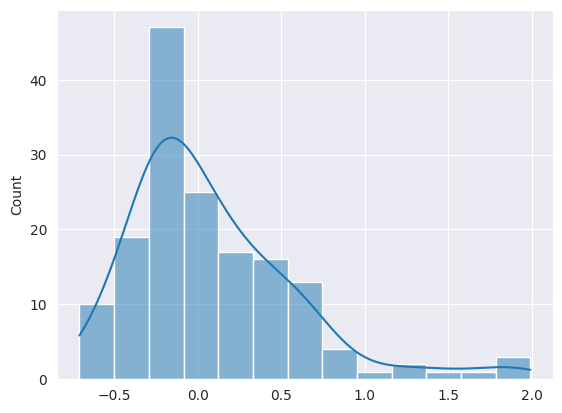

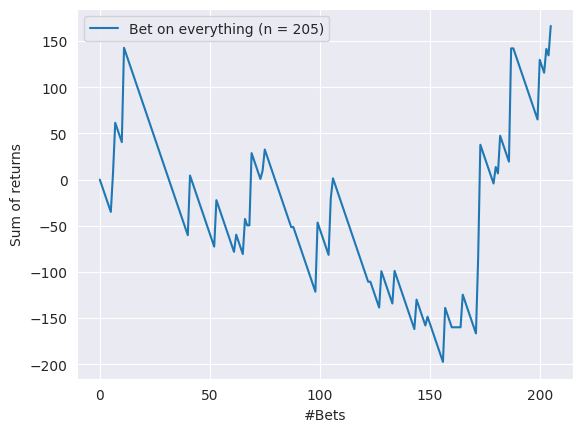

In [5]:
import pandas as pd
from Model.Betting.payout_calculation import BetfairPayoutCalculator
from Model.Betting.evaluate import WinBetEvaluator
from Model.Betting.bet import Bet
from typing import List
import os
from Persistence.RaceCardPersistence import RaceCardsPersistence
from tqdm import tqdm
from Model.Betting.race_results_container import RaceResultsContainer
from matplotlib import pyplot as plt
import pickle
import seaborn as sns
from numpy import cumsum, mean


def plot_test_bets_return(test_bets: List[Bet], axis, label: str) -> None:
    payout_values = [0.0] + [bet.payout for bet in test_bets]
    date_values = list(range(len(payout_values)))
    cum_payout_values = cumsum(payout_values)
    label = f"{label} (n = {len(test_bets)})"
    sns.lineplot(ax=axis, x=date_values, y=cum_payout_values, label=label)

TEST_BETS_PATH = "../data/bets_log"
test_bets = []

for file_name in os.listdir(TEST_BETS_PATH):
    if os.path.isfile(f"{TEST_BETS_PATH}/{file_name}"):
        with open(f"{TEST_BETS_PATH}/{file_name}", "rb") as f:
            test_bets += pickle.load(f)
    
race_cards_loader = RaceCardsPersistence("race_cards_release")
race_results_container = RaceResultsContainer()

test_sample_file_names = race_cards_loader.race_card_file_names[-2:]

print(test_sample_file_names)

race_cards = {}

for race_card_file_name in tqdm(test_sample_file_names):
    race_cards = race_cards_loader.load_race_card_files_non_writable([race_card_file_name])
    race_results_container.add_results_from_race_cards(race_cards)
    
bet_evaluator = WinBetEvaluator()
payout_calculator = BetfairPayoutCalculator(bet_evaluator)

payout_calculator.insert_payouts_into_bets(test_bets, race_results_container.race_results)

for bet in test_bets:
    if bet.payout == 0:
        print(bet)
        
bet_odds_sp_pairs = []
for bet in test_bets:
    race_card_id_bet = bet.bet_offer.race_card.race_id
    horse_number_bet = bet.bet_offer.horse.number
    horse_sp = 0
    for race_card in race_cards.values():
        # print(type(race_card.race_id))
        # print(type(race_card_id_bet))
        if str(race_card.race_id) == race_card_id_bet:
            for horse in race_card.horses:
                if horse.number == horse_number_bet:
                    horse_sp = horse.betfair_win_sp
                    
    bet_odds_sp_pairs.append((bet.bet_offer.odds, horse_sp))
     
win_prob_diffs = get_win_prob_diffs(bet_odds_sp_pairs)   

print(pd.Series(win_prob_diffs).describe())

sns.histplot(data=win_prob_diffs, kde=True)

fig, axes = plt.subplots(1, 1)

axes.set(xlabel="#Bets", ylabel="Sum of returns")
plot_test_bets_return(test_bets=test_bets, axis=axes, label="Bet on everything")

In [10]:
import numpy as np

bets = test_bets_base
n_successful_bets = len([bet for bet in bets if bet.payout > 0])
n_bets = len([bet for bet in bets if bet.payout != 0])

print(n_successful_bets)
print(n_bets)
print(n_successful_bets / n_bets)
print(np.mean([bet.bet_offer.odds for bet in test_bets_base if bet.payout > 0]))

NameError: name 'test_bets_base' is not defined

In [4]:
for bet in test_bets_base:
    print(bet)

-----------------------------------
Race: 6411535
Offer: Odds for Clenched: 12.0
Stakes: 0.06289786688899544
Payout: -0.06289786688899544
-----------------------------------

-----------------------------------
Race: 6411540
Offer: Odds for Alexi Boy: 3.25
Stakes: 0.05117977990976533
Payout: -0.05117977990976533
-----------------------------------

-----------------------------------
Race: 6409391
Offer: Odds for Pour Me A Drink: 9.0
Stakes: 0.00636915833092247
Payout: -0.00636915833092247
-----------------------------------

-----------------------------------
Race: 6411539
Offer: Odds for Pop Dancer: 5.8
Stakes: 0.010845725744067133
Payout: -0.010845725744067133
-----------------------------------

-----------------------------------
Race: 6417045
Offer: Odds for Sir Psycho: 4.9
Stakes: 0.06010038082627219
Payout: 0.22702918857124318
-----------------------------------

-----------------------------------
Race: 6417046
Offer: Odds for Cap Du Mathan: 4.2
Stakes: 0.013575863334212013
P

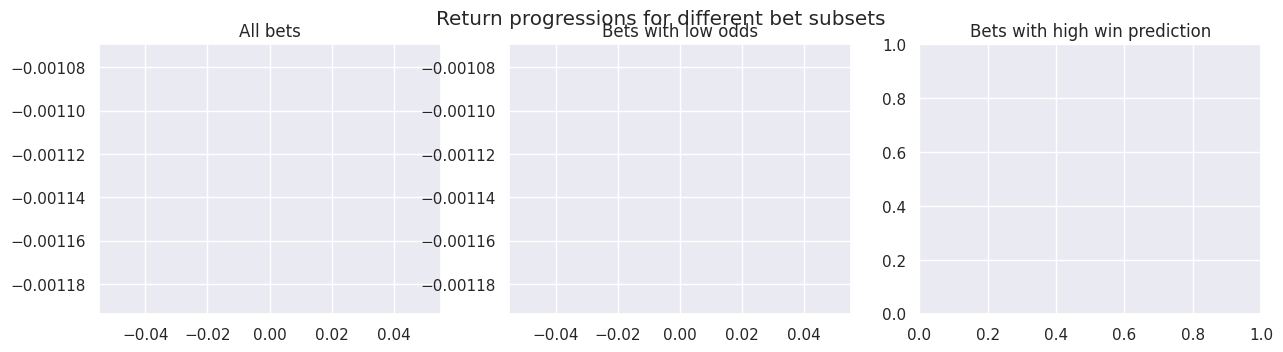

In [14]:
from Model.Betting.bet import Bet
from typing import List
import seaborn as sns
from matplotlib import pyplot as plt
from numpy import cumsum

sns.set(rc={'figure.figsize':(15,3.5)})

def plot_test_bets_return(axis, test_bets: List[Bet]) -> None:
    payout_values = [bet.payout for bet in test_bets]
    x = [i for i in range(len(payout_values))]
    cum_payout_values = cumsum(payout_values)
    sns.lineplot(ax=axis, x=x, y=cum_payout_values)

fig, axes = plt.subplots(1, 3)
fig.suptitle('Return progressions for different bet subsets')

axes[0].set_title("All bets")
plot_test_bets_return(axis=axes[0], test_bets=test_bets_base)

test_bets_low_odds = [bet for bet in test_bets_base if bet.bet_offer.odds < 20]
axes[1].set_title("Bets with low odds")
plot_test_bets_return(axis=axes[1], test_bets=test_bets_low_odds)

test_bets = [bet for bet in test_bets_base if bet.probability_estimate > 0.25]
axes[2].set_title("Bets with high win prediction")
plot_test_bets_return(axis=axes[2], test_bets=test_bets)